In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import math
from collections import Counter
from numpy import corrcoef

def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    
    # if not standard , compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z, low_p = -10.0, 0          # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1             # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2   # consider the midpoint
        mid_p = normal_cdf(mid_z)    # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
            
    return mid_z

#from linear algebra section

def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

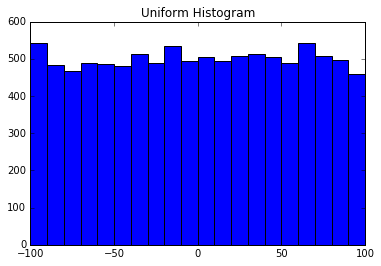

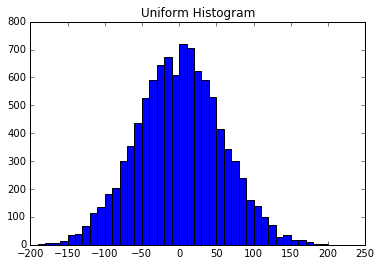

In [38]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()
    
random.seed(0)
# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# notmal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
          for _ in range(10000)]

plot_histogram(uniform, 10, "Uniform Histogram")
plot_histogram(normal, 10, "Uniform Histogram")

**Two Dimensions**

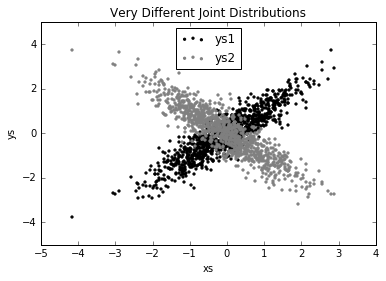

In [39]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

In [40]:
#print(correlation(xs, ys1))  #  0.9
#print(correlation(xs, ys2))  # -0.9

# NameError: name 'correlation' is not defined

print(corrcoef(xs, ys1))  #  0.9
print(corrcoef(xs, ys2))  # -0.9
print((corrcoef(xs, ys2))[1,0])

[[ 1.          0.90104937]
 [ 0.90104937  1.        ]]
[[ 1.         -0.89209815]
 [-0.89209815  1.        ]]
-0.892098152688


**Many Dimensions**

In [41]:
# unused?
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between coumns i and j of data"""
    
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)


                       

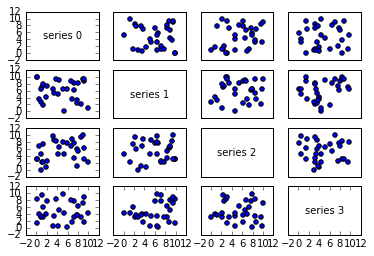

In [42]:
import matplotlib.pyplot as plt

### helper function
num_rows = 30
num_columns = 4
data = [None] * num_columns
for i in range(num_columns):
    data[i] = [None] * num_rows
for i in range(num_columns):
    for j in range(num_rows):
        data[i][j] = random.random() * 10


###
num_columns, _ = shape(data)  # reversed column and row to make get_column easier
fig, ax = plt.subplots(num_columns, num_columns)

def get_column(matrix, column):
    return matrix[column]

for i in range(num_columns):
    for j in range(num_columns):
        
        #scatter column_j on the x-axis vs column_i in the y-axis
        if i != j: 
            ax[i][j].scatter(get_column(data, j), get_column(data, i))
        
        # unless i == j, in which case show the series name
        else:
            ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                             xycoords='axes fraction',
                             ha="center", va="center")
        
        #then hide axis labels except left and bottom charts
        if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

# fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()



**Cleaning and Munging**

In [43]:
import csv

def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)
        
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

import dateutil.parser
data = []

with open("comma_delimited_stock_prices.csv", "rt") as f: # python3 b to t
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)

for row in data:
    if any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]


In [44]:
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from 
    parser dict"""
    parser = parser_dict.get(field_name) # none if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
            for field_name, value in input_dict.iteritems()}

# not tested for output?

** Manipulating Data **

In [45]:
import os
import pandas as pd

if os.path.isfile('stocks.txt'):
    stocks = pd.read_csv('stocks.txt', sep="\t")
    data = stocks.to_dict("records")
    # http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.to_dict.html
    
# print(help(pd.read_csv))
    

In [46]:
import datetime
from collections import defaultdict

# use data from file
# data = [ 
#       {'closing_price' : 102.06,
#        'date' : datetime.datetime(2014, 8, 29, 0, 0),
#        'symbol' : 'AAPL'},
#        # ...
#       ]

max_aapl_price = max(row["closing_price"]
                     for row in data
                     if row["symbol"] == "AAPL")

# group rows by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)
    
# use a dict comprehension to find the max for each symbol
max_price_by_symbol = { symbol : max(row["closing_price"]
                                    for row in grouped_rows)
                        for symbol, grouped_rows in by_symbol.items()
}

print(max_aapl_price)
# print(by_symbol)
print(list(by_symbol))
print(max_price_by_symbol)

119.0
['MSFT', 'AAPL', 'FB']
{'MSFT': 49.3, 'AAPL': 119.0, 'FB': 81.45}


In [47]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                 for key, rows in grouped.items() }
    
max_price_by_symbol = group_by(picker("symbol"),
                              data,
                              lambda rows: max(pluck("closing_price", rows)))


print(max_price_by_symbol)


{'MSFT': 49.3, 'AAPL': 119.0, 'FB': 81.45}


In [48]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # fort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    
    # zip with an offset to get pairs of consecutive days
    return [ { "symbols" : today["symbol"],
               "date" : today["date"],
               "change" : percent_price_change(yesterday, today) }
            for yesterday, today in zip(ordered, ordered[1:])]

# key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)

#collect all "change" dicts into one big list
all_changes = [change
               for changes in changes_by_symbol.values()
               for change in changes]

print(max(all_changes, key=picker("change")))
# {'change': 0.3283582089552237,
#    'date': datetime.datetime(1997, 8, 6, 0, 0),
#    'symbol': 'AAPL'}
# see, e.g. http://news.cnet.com/2100-1001-202143.html

print(min(all_changes, key=picker("change")))
# {'change': -0.5193370165745856,
#    'date': datetime.datetime(2000, 9, 29, 0, 0),
#    'symbol': 'AAPL'}
# see, e.g. http://oney.cnn.com/2000/09/29/merrkets/techwrap


# print(all_changes)
# no data provided in all_changes to test

{'date': '1997-08-06', 'change': 0.3283582089552237, 'symbols': 'AAPL'}
{'date': '2000-09-29', 'change': -0.5193370165745856, 'symbols': 'AAPL'}


In [49]:
from functools import reduce
# to combine percent changes, we add 1 to each, multiply them, and subtract 1
# for instance, if we combine +10% and -20%, the overall change is 
# (1 + 10%) * (1 - 20%) - 1 = 1.1 * 0.7 - 1 = -12%

def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

# overall_change_by_month = group_by(lambda row: row['date'].month,
overall_change_by_month = group_by(lambda row: row['date'][5:7],
                                    all_changes,
                                    overall_change)
print(sorted(overall_change_by_month.items()))


[('01', 19.972214514609103), ('02', 0.11858483359215), ('03', 2.8188500486033288), ('04', 6.9341967849847554), ('05', 1.2555660890321625), ('06', -0.5977889232201758), ('07', -0.17183091713561038), ('08', 6.220055959879472), ('09', -0.741162543642831), ('10', 21.552541251680065), ('11', 3.758572336791741), ('12', 2.2895332950256013)]


# Rescaling #

| Person | Height (inches) | Height (centimeters) | Weight |
| :---: | :---: |:---: | :---: |
| A | 63 inches | 160 cm | 150 pounds |
| B | 67 inches | 170.2 cm | 160 pounds | 
| C | 70 inches | 177.8 cm | 171 pounds |


In [50]:
# from Chapter 4
import math

def sum_of_squares(v):
    """v_1 * v_2 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v, w):
    """(v_1 - w_1) ** 2 + ... _ (v_n - w_n) ** 2"""
    return sum_of_squares(vector_subtract(v, w))
             
def vector_subtract(v, w):
    """adds corresponding elemetns"""
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i
              for v_i, w_i in zip(v, w))

def distance(v, w):
    return math.sqrt(squared_distance(v, w))

In [51]:
a_to_b = distance([63, 150], [67, 160])
a_to_c = distance([63,150], [70,171])
b_to_c = distance([67, 160], [70, 171])
print (a_to_b)
print (a_to_c)
print (b_to_c)

10.770329614269007
22.135943621178654
11.40175425099138


In [52]:
a_to_b = distance([160, 150], [170.2, 160])
a_to_c = distance([160,150], [177.8,171])
b_to_c = distance([170.2, 160], [177.8, 171])
print (a_to_b)
print (a_to_c)
print (b_to_c)

14.284257068535268
27.52889391167034
13.370115930686627


In [53]:
# from Chapter 5
def de_mean(x):
    """translate x by subtracting it mean (so the result has mean 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x):
    return math.sqrt(variance(x))

In [54]:
# from Chapter 4 
def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j)
            for j in range(num_cols)]
            for i in range(num_rows)]

In [55]:
# from Chapter 5

def mean(x):
    return sum(x) / len(x)

In [56]:
def scale(data_matrix):
    """returns the means and standard deviations of each column"""
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix, j))
            for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix, j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    leaves alone columns with no deviation"""
    means, stdevs = scale(data_matrix)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]
        
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

#untested
array1 = [False for _ in range(2)]
xs = [random_normal() for _ in range(1000)]
array1[0] = [ 3 + x + 5 * random_normal() / 2 for x in xs]
array1[1] = [ 5 + x + 15 * random_normal() / 2 for x in xs]
array1 = list(zip (*array1))
print(scale(array1))

array2 = rescale(array1)
print(scale(array2))


([3.393038749694824, 5.990604400634766], [4.730597343040707, 1.098921418032799])
([-0.013460005788165863, 0.5459720992935617], [0.9809646772647553, 0.2278788525017348])


# Dimensionality Reduction #

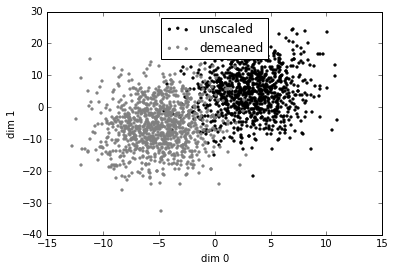

In [57]:
def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean
    value of its column.  the resulting matrix has mean 0 in every column"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])


# testing
array1 = [False for _ in range(2)]
xs = [random_normal() for _ in range(1000)]
array1[0] = [ 3 + x + 5 * random_normal() / 2 for x in xs]
array1[1] = [ 5 + x + 15 * random_normal() / 2 for x in xs]
array1 = list(zip (*array1))

plt.scatter(list(zip (*array1))[0], list(zip (*array1))[1] , marker='.', color='black', label='unscaled')

array2 = de_mean_matrix(array1)

plt.scatter(list(zip (*array2))[0], list(zip (*array2))[1], marker='.', color='gray', label='demeaned')

plt.xlabel('dim 0')
plt.ylabel('dim 1')
plt.legend(loc=9)
plt.show()

In [58]:
# from Chapter 8
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stachastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)

In [59]:
# from Chapter 4
def magnitude(v):
    return math.sqrt(sum_of_squares(v))

def vector_add(v, w):
    """adds corresponding elements"""
    return [v_i + w_i for v_i, w_i in zip(v, w)]
             
def vector_subtract(v, w):
    """adds corresponding elemetns"""
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def vector_sum(vectors):
    """sums all correspoinding elements"""
    return reduce(vector_add, vectors)

In [60]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

# print(direction([1,5]))  # to test

def directional_variance_i(x_i, w):
    """the variace of the row x_i in the direction determined by w"""
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction determined w"""
    return sum(directional_variance_i(x_i, w)
              for x_i in X)

# print(directional_variance(array1, [2,5]))

def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_u to the gradient of the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i, w)
                     for x_i in X)

# print(directional_variance_gradient(array1, [2,5]))

In [61]:
# from Chapter 8
from functools import partial

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient decent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    theta = theta_0                    # set theta to initial value
    target_fn = safe(target_fn)        # safe version of target_fn
    value = target_fn(theta)           # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]
        
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
            
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                         negate_all(gradient_fn),
                         theta_0,
                         tolerance)

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    
    data = zip(x, y)
    theta = theta_0                           # initial guess
    alpha = alpha_0                           # initial step size
    min_theta, min_value = None, float("inf") # the minimum so fat 
    iterations_with_no_improvement = 0
    
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )
        
        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_Value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else: 
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_1 = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)

def safe(f):
    """return a new function that's the same as f,
    except that it outputs infinity whenever f produces an error"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')       # this means "infiinity" in Python
    return safe_f

def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

def in_random_order(data):
    """generate that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

In [62]:
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),  # is now a function of w
        partial(directional_variance_gradient, X),  # is now a function of w
        guess)
#     print("unscaled_maximizer ", unscaled_maximizer)
    return direction(unscaled_maximizer)

# here there is no "y", so we just pass in a vector of Nones
# and functions that ignore that input
def first_principal_component_sqd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X,
        [None for _ in X],   # the fake "y"
        guess)
    print("unscaled_maximizer ", unscaled_maximizer)
    return direction(unscaled_maximizer)

# print(first_principal_component(array1))
# print(first_principal_component_sqd(array1))

In [67]:
# from Chapter 4
def scalar_multiply(c, v):
    """c is a number, v is a vector"""
    return [c * v_i for v_i in v]

In [69]:
def project(v, w):
    """return the projection of v onyto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

print(project([3,4], [1,0]))

def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return vector_subtract(v, project(v, w))

print(remove_projection_from_vector([3,4], [1,0]))

def remove_projection(X, w):
    """for each row of X 
    projects the row onto w, and subtracts the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

print(remove_projection(array1, [1,0]))


SyntaxError: invalid syntax (<ipython-input-69-72454e10d646>, line 12)

In [ ]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
        return components
    
def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

##output unchecked